<a href="https://colab.research.google.com/github/Dibyasundar/MJCN/blob/master/MJCN_ISIK_BANGLA_NUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install sklearn_extensions

import scipy.io as io
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Flatten, Layer, Activation, MaxPool2D
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
from mlxtend.data import loadlocal_mnist
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn_extensions.extreme_learning_machines.elm import GenELMClassifier as ELM_clf
from sklearn_extensions.extreme_learning_machines.random_layer import MLPRandomLayer as rand_l
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
import warnings
warnings.filterwarnings("ignore")
import cv2
from keras.optimizers import SGD
from keras import models

  Created wheel for sklearn-extensions: filename=sklearn_extensions-0.0.2-py2.py3-none-any.whl size=24578 sha256=074148422972dafeef97674cc8dae6249c5d7d65910dd1d5af0ee0b8116d9001
  Stored in directory: /root/.cache/pip/wheels/b5/26/b2/09100728168b45e4de834b943a588028744fdfaa9ac979ffb2
Successfully built sklearn-extensions


Using TensorFlow backend.


In [0]:
def img_resize(img):
    for i in range(img.shape[0]):
        d = img[i,:,:]
        if i==0:
            xxx=cv2.resize(d, (40, 40))
            xxx=np.expand_dims(xxx,axis=0)
        else:
            nnn=cv2.resize(d, (40, 40))
            nnn=np.expand_dims(nnn,axis=0)
            xxx=np.append(xxx,nnn,axis=0)
    return(xxx)


class MyLayer(Layer):
    def __init__(self,dim, **kwargs):
        self.dim=dim
        super(MyLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', shape=(self.dim), initializer='uniform',trainable='false')
        super(MyLayer, self).build(input_shape)
    def call(self, x):
        dd=self.kernel
        for i in range(dd.shape[2]):
            if i==0:
                cd=tf.transpose(K.dot(tf.transpose(x,[0,3,1,2]), dd[:,:,i]),[0,2,3,1])
            else:
                cd = cd + tf.transpose(K.dot(tf.transpose(x,[0,3,1,2]), dd[:,:,i]),[0,2,3,1])
        return K.sum(cd,axis=3)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.dim[1])



def new_model(m,n,p):
    model=Sequential()
    model.add(Conv2D(8, kernel_size = (5,5), input_shape = (m,n,p), padding='same'))
    model.add(Activation('sigmoid'))
    model.add(MyLayer((n,10,2)))
    model.add(Flatten())
    model.add(Activation('sigmoid'))
    return(model)
def obj_eval(data, model):
    m = []
    v = []
    for i in range(len(data)):
        out = model.predict(data[i], steps=1)
        m.append(np.mean(out, axis=0))
        v.append(np.var(out, axis=0))
    mt=np.mean(np.array(m),axis=0)
    m_obj = 0;
    v_obj = 0
    for i in range(len(m)):
        for j in range(i+1,len(m),1):
            m_obj=m_obj+ np.sqrt(np.sum(np.square(m[i]-m[j])))
        m_obj=m_obj + np.sqrt(np.sum(np.square(mt-m[j])))
        v_obj=v_obj+np.sum(v[i])
    return m_obj, v_obj




def initialize_pop(w):
    pop=[]
    for i in range(len(w)):
        pop.append((-1+np.random.random(w[i].shape)*2)*0.1)
    return pop
def initialize_vel(w):
    vel=[]
    for i in range(len(w)):
        vel.append(np.random.random(w[i].shape))
    return vel



def get_feature(data,model):
    for i in range(len(data)):
        out = model.predict(data[i], steps=1)
        if i==0:
            feature = np.array(out)
            label = np.ones((out.shape[0],1))*i
        else:
            feature = np.append(feature,out,axis=0)
            label = np.append(label, np.ones((out.shape[0],1))*i,axis=0)
    return feature, label



def precision(label, confusion_matrix):
    tp = confusion_matrix[label, label];
    fn = np.sum(confusion_matrix[label, :]) - tp;
    fp = np.sum(confusion_matrix[:, label]) - tp;
    tn = np.sum(confusion_matrix) - (tp+fp+fn)
    return (tp)/(tp+fp)
    
def recall(label, confusion_matrix):
    tp = confusion_matrix[label, label];
    fn = np.sum(confusion_matrix[label, :]) - tp;
    fp = np.sum(confusion_matrix[:, label]) - tp;
    tn = np.sum(confusion_matrix) - (tp+fp+fn)
    return (tp)/(tp+fn)

def accuracy_f(label, confusion_matrix):
    tp = confusion_matrix[label, label];
    fn = np.sum(confusion_matrix[label, :]) - tp;
    fp = np.sum(confusion_matrix[:, label]) - tp;
    tn = np.sum(confusion_matrix) - (tp+fp+fn)
    return (tp+tn)/(tp+tn+fp+fn)
def tp_f(label, confusion_matrix):
    tp = confusion_matrix[label, label];
    fn = np.sum(confusion_matrix[label, :]) - tp;
    fp = np.sum(confusion_matrix[:, label]) - tp;
    tn = np.sum(confusion_matrix) - (tp+fp+fn)
    return tp,fn,fp,tn



def k_nn(train_feature,train_label,test_feature,test_label):
    cls=knn(n_neighbors=1)
    cls.fit(train_feature, train_label.ravel())
    p = cls.predict(test_feature)
    no_cl = np.unique(train_label).shape[0]
    conf = confusion_matrix(test_label.ravel(),p)  
    acc=np.sum(np.diagonal(conf))/np.sum(conf)
    return(acc)
def ELM(train_feature,train_label,test_feature,test_label):
    cls=ELM_clf(hidden_layer=rand_l(n_hidden=200, activation_func='sigmoid'))
    cls.fit(train_feature, train_label.ravel())
    p = cls.predict(test_feature)
    no_cl = np.unique(train_label).shape[0]
    conf = confusion_matrix(test_label.ravel(),p)  
    acc=np.sum(np.diagonal(conf))/np.sum(conf)
    return(acc)
def svc_new(train_feature,train_label,test_feature,test_label):
    cls=SVC(C=10000,gamma=10,kernel='rbf',random_state=None,tol=0.000001,coef0=0,degree=2,decision_function_shape='ovr')
    cls.fit(train_feature, train_label.ravel())
    p = cls.predict(test_feature)
    no_cl = np.unique(train_label).shape[0]
    conf = confusion_matrix(test_label.ravel(),p) 
    acc=np.sum(np.diagonal(conf))/np.sum(conf)
    return(acc)
def mlp_new(train_feature,train_label,test_feature,test_label):
    cls=MLP(solver='adam', alpha=0.00003, hidden_layer_sizes=(100,20), tol=0.00001, activation='identity', max_iter=5000)
    cls.fit(train_feature, train_label.ravel())
    p = cls.predict(test_feature)
    no_cl = np.unique(train_label).shape[0]
    conf = confusion_matrix(test_label.ravel(),p)    
    acc=np.sum(np.diagonal(conf))/np.sum(conf)
    return(acc)

In [0]:
if not os.path.exists('ISIK_BANGLA_NUM_Train.mat'):
    train_full=[]
    data_path='/home/drago/store/Dataset_Raw/OCR Dataset/ISI OCR Datasets/Oriya Handwritten Numeral/Train'
    list_folder=sorted(os.listdir(data_path))
    train_data_set=[]
    for fo in list_folder:
        k=0;
        list_files=os.listdir(data_path+'/'+fo)
        d=[]
        for f in list_files:
            if f.endswith('.tif'):
                d.append(f)
            if f.endswith('.png'):
                d.append(f)
            if f.endswith('.jpg'):
                d.append(f)
        for f in d:
            if k==0:
                img_set=plt.imread(data_path+'/'+fo+'/'+f)
                img_set=cv2.resize(img_set, (40, 40))
                th,img_set=cv2.threshold(img_set,130,255,cv2.THRESH_BINARY)
                img_set=(1- img_set/255)
                img_set=(img_set-np.mean(img_set))
                img_set=img_set/(np.std(img_set))
                img_set=np.expand_dims(img_set,axis=0)
                img_set=np.expand_dims(img_set,axis=3)
                k=1
            else:
                img=plt.imread(data_path+'/'+fo+'/'+f)
                img=cv2.resize(img, (40, 40))
                th,img=cv2.threshold(img,130,255,cv2.THRESH_BINARY)
                img=(1- img/255)
                img=(img-np.mean(img))
                img=img/(np.std(img))
                img=np.expand_dims(img,axis=0)
                img=np.expand_dims(img,axis=3)
                img_set=np.append(img_set,img,axis=0)
        print(img_set.shape)
        train_data_set.append(img_set)
    print(len(train_data_set))
    io.savemat('ISIK_BANGLA_NUM_Train.mat',{'train_data_set':train_data_set})
    mat_train = io.loadmat('ISIK_BANGLA_NUM_Train.mat')
else:
    mat_train = io.loadmat('ISIK_BANGLA_NUM_Train.mat')

train_data_set=mat_train['train_data_set'][0]

In [0]:
if not os.path.exists('ISIK_BANGLA_NUM_Test.mat'):
    data_path='/home/drago/store/Dataset_Raw/OCR Dataset/ISI OCR Datasets/Oriya Handwritten Numeral/Test'
    list_folder=sorted(os.listdir(data_path))
    test_data_set=[]
    for fo in list_folder:
        k=0;
        list_files=os.listdir(data_path+'/'+fo)
        d=[]
        for f in list_files:
            if f.endswith('.tif'):
                d.append(f)
            if f.endswith('.png'):
                d.append(f)
            if f.endswith('.jpg'):
                d.append(f)
        for f in d:
            if k==0:
                img_set=plt.imread(data_path+'/'+fo+'/'+f)
                img_set=cv2.resize(img_set, (40, 40))
                th,img_set=cv2.threshold(img_set,130,255,cv2.THRESH_BINARY)
                img_set=(1- img_set/255)
                img_set=(img_set-np.mean(img_set))
                img_set=img_set/(np.std(img_set))
                img_set=np.expand_dims(img_set,axis=0)
                img_set=np.expand_dims(img_set,axis=3)
                k=1
            else:
                img=plt.imread(data_path+'/'+fo+'/'+f)
                img=cv2.resize(img, (40, 40))
                th,img=cv2.threshold(img,130,255,cv2.THRESH_BINARY)
                img=(1- img/255)
                img=(img-np.mean(img))
                img=img/(np.std(img))
                img=np.expand_dims(img,axis=0)
                img=np.expand_dims(img,axis=3)
                img_set=np.append(img_set,img,axis=0)
        print(img_set.shape)
        test_data_set.append(img_set)
    print(len(test_data_set))
    io.savemat('ISIK_BANGLA_NUM_Test.mat',{'test_data_set':train_data_set})
    mat_train = io.loadmat('ISIK_BANGLA_NUM_Test.mat')
else:
    mat_train = io.loadmat('ISIK_BANGLA_NUM_Test.mat')

test_data_set=mat_train['test_data_set'][0]

In [0]:
sz_f_data=[10,20,50,100,150,200,450]
sz_t_data=[10,20,50,100,150,200,450]
for k in range(len(sz_f_data)):
    pop_sz = 50
    MaxIter= 200
    train_full=np.array(train_data_set)
    train_set=[]
    for i in range(train_full.shape[0]):
        n_data=train_full[i]
        sz = n_data.shape
        pos = np.random.permutation(sz[0])
        train_set.append(n_data[pos[0:sz_f_data[k]],:,:,:])
    sz = train_set[0].shape
    model = new_model(sz[1],sz[2],sz[3])
    w = model.get_weights()
    pop = []
    vel = []
    for i in range(pop_sz):
        pop.append(initialize_pop(w))
    pop=np.array(pop)
    for i in range(pop_sz):
        vel.append(initialize_vel(w))
    vel=np.array(vel)
    m_obj=[]
    v_obj=[]
    for i in range(pop_sz):
        model.set_weights(pop[i])
        [m, v] = obj_eval(train_set,model)
        m_obj.append(np.copy(m))
        v_obj.append(np.copy(v))
    m_obj = np.array(m_obj)
    v_obj = np.array(v_obj)
    it=1
    plot_g_m=[]
    plot_g_v=[]
    while it<= MaxIter:
        obj =0.2*(m_obj/np.sum(m_obj)) -  0.8*(v_obj/np.sum(v_obj))
        g_best=np.argmax(obj)
        global_best=np.copy(pop[g_best])
        global_best_m_obj=np.copy(m_obj[g_best])
        global_best_v_obj=np.copy(v_obj[g_best])
        g_worst=np.argmin(obj)
        global_worst=np.copy(pop[g_worst])
        global_worst_m_obj=np.copy(m_obj[g_worst])
        global_worst_v_obj=np.copy(v_obj[g_worst])
        print("iteration:{}\t global m:{}\t global v:{}\t mean_m:{}\t mean_v:{}".format(it,global_best_m_obj,global_best_v_obj,np.mean(m_obj),np.mean(v_obj)))
        for i in range(pop_sz):
            npop = pop[i] + np.multiply(np.random.random(pop[i].shape), global_best-np.abs(pop[i])) - np.multiply(np.random.random(pop[i].shape), global_worst-np.abs(pop[i]))
            model.set_weights(npop)
            [m, v] = obj_eval(train_set,model) 
            if (m>m_obj[i] and v<v_obj[i]) or (m>m_obj[i] and v==v_obj[i]) or(m==m_obj[i] and v<v_obj[i]):#(m-v>m_obj[i]-v_obj[i]):
                pop[i] = np.copy(npop)
                m_obj[i] = np.copy(m)
                v_obj[i] = np.copy(v)
            else:
                npop=pop[i]+(np.multiply(np.random.random(pop[i].shape),global_best)-np.multiply(np.random.random(pop[i].shape),global_worst))/2
                model.set_weights(npop)
                [m, v] = obj_eval(train_set,model) 
                if (m>m_obj[i] and v<v_obj[i]) or (m>m_obj[i] and v==v_obj[i]) or(m==m_obj[i] and v<v_obj[i]):#(m-v>m_obj[i]-v_obj[i]):
                    pop[i] = np.copy(npop)
                    m_obj[i] = np.copy(m)
                    v_obj[i] = np.copy(v)
        plot_g_m.append(global_best_m_obj)
        plot_g_v.append(global_best_v_obj)
        it = it+1
    obj = m_obj-v_obj#0.2*(m_obj/np.sum(m_obj)) -  0.8*(v_obj/np.sum(v_obj))
    g_best=np.argmax(obj)
    global_best=np.copy(pop[g_best])
    model.set_weights(global_best)
    [m,v]=obj_eval(train_set,model)
    print('per class sample Feature\t|per class sample train_sz\t|k_nn\t|ELM\t|SVM\t|BPNN\t|')
    print('-----------------------------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    for kk in range(len(sz_t_data)):
        train_full=np.array(train_data_set)
        train_set=[]
        for i in range(train_full.shape[0]):
            n_data=train_full[i]
            sz = n_data.shape
            pos = np.random.permutation(sz[0])
            train_set.append(n_data[pos[0:sz_t_data[kk]],:,:,:])
        train_feature, train_label = get_feature(train_set,model)
        test_feature, test_label = get_feature(test_data_set,model)
        acc1=k_nn(train_feature,train_label,test_feature,test_label)
        acc2=ELM(train_feature,train_label,test_feature,test_label)
        acc3=svc_new(train_feature,train_label,test_feature,test_label)
        acc4=mlp_new(train_feature,train_label,test_feature,test_label)
        print('{}\t\t\t|{}\t\t\t|{}\t|{}\t|{}\t|{}\t|'.format(sz_f_data[k],sz_t_data[kk],acc1,acc2,acc3,acc4))











iteration:1	 global m:3.484053786844015	 global v:0.16396969184279442	 mean_m:9.232855295538902	 mean_v:0.7184923821687699
iteration:2	 global m:3.484053786844015	 global v:0.16396969184279442	 mean_m:9.402315825819969	 mean_v:0.7127872384339571
iteration:3	 global m:7.376388099044561	 global v:0.12575756292790174	 mean_m:9.718101768121123	 mean_v:0.6949260285682977
iteration:4	 global m:3.9372956417500973	 global v:0.04294851468876004	 mean_m:9.817206177785993	 mean_v:0.6862083111982793
iteration:5	 global m:3.9372956417500973	 global v:0.04294851468876004	 mean_m:9.856667693033815	 mean_v:0.6817088087741285
iteration:6	 global m:3.9372956417500973	 global v:0.04294851468876004	 mean_m:9.96819555900991	 mean_v:0.6730779915396125
iteration:7	 global m:3.9372956417500973	 global v:0.04294851468876004	 mean_m:10.108903336450458	 mean_v:0.6632569423783571
iteration:8	 global m:3.9372956417500973	 global v:0.04294851468876004	 mean_m:10.161512166783213	 mean_v:0.6585568973142654
i

In [0]:
train_data_set[0].shape

(502, 40, 40, 1)

In [0]:
acti_model = models.Model(inputs=model.input, outputs=model.layers[1].output)
acti_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 40, 8)         208       
_________________________________________________________________
activation_13 (Activation)   (None, 40, 40, 8)         0         
Total params: 208
Trainable params: 208
Non-trainable params: 0
_________________________________________________________________


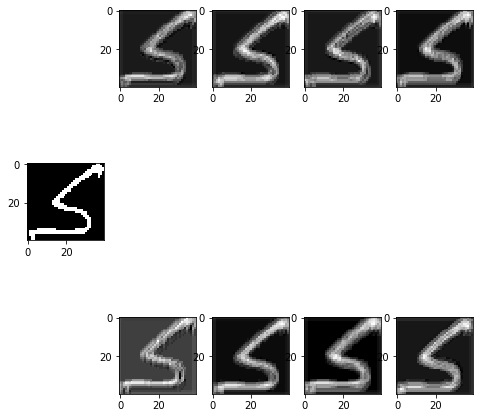

In [0]:
img=train_set[6][10]
img=np.expand_dims(img,axis=0)
p=acti_model.predict(img)
img=img[0,:,:,0]
img = (img-np.min(img))/(np.max(img)-np.min(img))
img=img*255
fig=plt.figure(figsize=(8,8))
fig.add_subplot(3,5,6)
plt.imshow(img,cmap='gray')
t=[2,3,4,5,12,13,14,15]
for i in range(p.shape[3]):
    img=p[0,:,:,i]
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img=img*255
    fig.add_subplot(3,5,t[i])
    plt.imshow(img,cmap='gray')
plt.show()